In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import torch.nn as nn

In [2]:
words = open("../names.txt").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
alphabet = ["."] + list("abcdefghijklmnopqrstuvwxyz")
stoi = {c: i for i, c in enumerate(alphabet)}
itos = {i: c for i, c in enumerate(alphabet)}
vocab_size = len(itos)

In [5]:
block_size = 3
def build_dataset(words):
    random.seed(42)
    random.shuffle(words)
    
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)

    n1 = int(0.8 * len(words))
    n2 = int(0.9 * len(words))

    Xtr, Ytr = X[:n1], Y[:n1]
    Xdev, Ydev = X[n1:n2], Y[n1:n2]
    Xte, Yte = X[n2:], Y[n2:]

    return Xtr, Ytr, Xdev, Ydev, Xte, Yte

Xtr, Ytr, Xdev, Ydev, Xte, Yte = build_dataset(words)

In [6]:
n_embed = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

In [7]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed))
W1 = torch.empty((n_embed * block_size, n_hidden))
b1 = torch.randn(n_hidden) * 0.01
W2 = torch.empty((n_hidden, n_hidden))
b2 = torch.randn(n_hidden) * 0.01
W3 = torch.randn((n_hidden, vocab_size)) * 0.01
b3 = torch.randn(vocab_size) * 0.01

bn1_gain = torch.ones((1, n_hidden))
bn1_bias = torch.ones((1, n_hidden)) * 0.01

bn2_gain = torch.ones((1, n_hidden))
bn2_bias = torch.ones((1, n_hidden)) * 0.01

# kaiming init
nn.init.kaiming_normal_(W1, a=0.01)
nn.init.kaiming_normal_(W2, a=0.01)

parameters = [C, W1, b1, W2, b2, W3, b3, bn1_gain, bn1_bias, bn2_gain, bn2_bias]

for p in parameters:
    p.requires_grad = True


In [8]:
max_steps = 30000
batch_size = 64
lossi = []

act = torch.nn.LeakyReLU()
for i in range(max_steps):

    # minibatch construct
    batch_ixs = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[batch_ixs], Ytr[batch_ixs]

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    h1_preact = emb.view(emb.shape[0], -1) @ W1 + b1
    # batch norm
    h1_preact = (h1_preact - h1_preact.mean(0, keepdim=True)) / h1_preact.std(0, keepdim=True)
    # scale and shift
    h1_preact = bn1_gain * h1_preact + bn1_bias
    h1 = act(h1_preact)

    h2_preact = h1 @ W2 + b2
    # batch norm
    h2_preact = (h2_preact - h2_preact.mean(0, keepdim=True)) / h2_preact.std(0, keepdim=True)
    # scale and shift
    h2_preact = bn2_gain * h2_preact + bn2_bias
    h2 = act(h2_preact)

    logits = h2 @ W3 + b3
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 10000 else 0.01 if i < 20000 else 0.005
    for p in parameters:
        p.data -= lr * p.grad
    
    # track stats
    if i % 5000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    break

      0/  30000: 3.2925


In [9]:
emb.shape

torch.Size([64, 3, 10])

In [10]:
W1.shape

torch.Size([30, 200])

In [11]:
-torch.log(torch.tensor(1/27.))

tensor(3.2958)

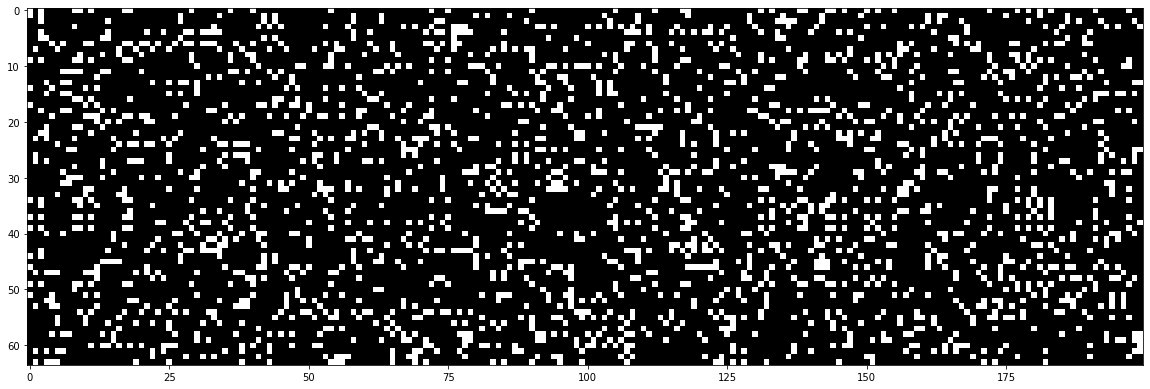

In [12]:
plt.figure(figsize=(20, 10))
plt.imshow(h1.abs() > 0.99, cmap="gray");

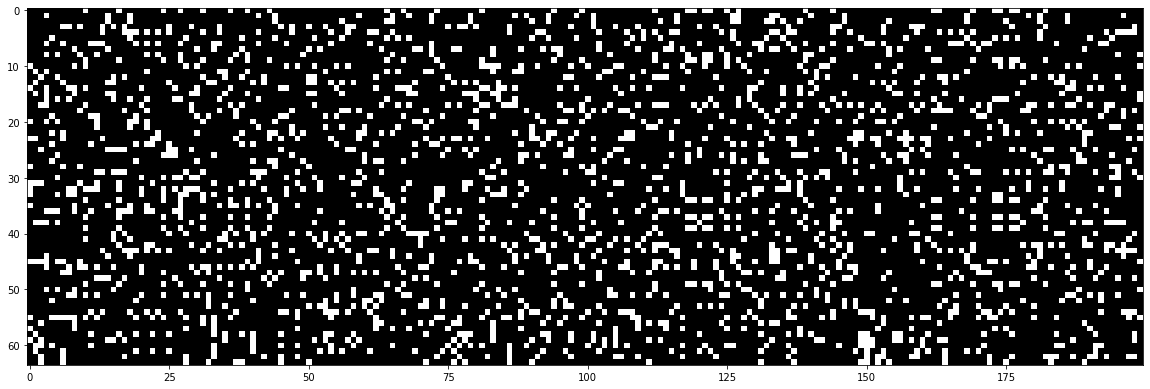

In [13]:
plt.figure(figsize=(20, 10))
plt.imshow(h2.abs() > 0.99, cmap="gray");

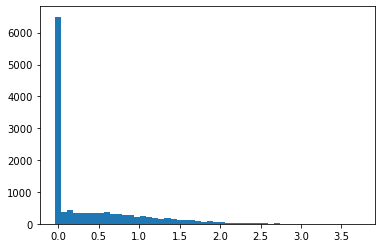

In [14]:
plt.hist(h1.view(-1).tolist(), 50);

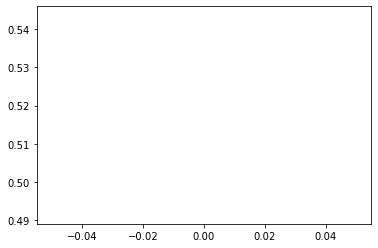

In [15]:
plt.plot(lossi);

In [16]:
with torch.no_grad():
    emb = C[Xtr]
    h1_preact = emb.view(emb.shape[0], -1) @ W1 + b1

    h1_bn_mean = h1_preact.mean(0, keepdim=True)
    h1_bn_std = h1_preact.std(0, keepdim=True)

    # batch norm
    h1_preact = (h1_preact - h1_preact.mean(0, keepdim=True)) / h1_preact.std(0, keepdim=True)
    # scale and shift
    h1_preact = bn1_gain * h1_preact + bn1_bias
    h1 = act(h1_preact) # (N, n_hidden)
    h2_preact = h1 @ W2 + b2

    h2_bn_mean = h2_preact.mean(0, keepdim=True)
    h2_bn_std = h2_preact.std(0, keepdim=True)

In [17]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte)
    }[split]
    emb = C[x] # (N, block_size, n_embed)
    
    h1_preact = emb.view(emb.shape[0], -1) @ W1 + b1
    # batch norm
    h1_preact = (h1_preact - h1_bn_mean) / h1_bn_std
    # scale and shift
    h1_preact = bn1_gain * h1_preact + bn1_bias
    h1 = act(h1_preact) # (N, n_hidden)

    h2_preact = h1 @ W2 + b2
    # batch norm
    h2_preact = (h2_preact - h2_bn_mean) / h2_bn_std
    # scale and shift
    h2_preact = bn2_gain * h2_preact + bn2_bias
    h2 = act(h2_preact) # (N, n_hidden)

    logits = h2 @ W3 + b3 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss("val")
split_loss("test")

val 3.1109330654144287
test 3.111248731613159


In [18]:
# sample from the model
g = torch.Generator(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1, block_size, n_embed)
        
        h1_preact = emb.view(emb.shape[0], -1) @ W1 + b1
        # batch norm
        h1_preact = (h1_preact - h1_bn_mean) / h1_bn_std
        # scale and shift
        h1_preact = bn1_gain * h1_preact + bn1_bias
        h1 = act(h1_preact) # (1, n_hidden)

        h2_preact = h1 @ W2 + b2
        # batch norm
        h2_preact = (h2_preact - h2_bn_mean) / h2_bn_std
        # scale and shift
        h2_preact = bn2_gain * h2_preact + bn2_bias
        h2 = act(h2_preact) # (1, n_hidden)

        logits = h2 @ W3 + b3 # (1, vocab_size)
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, replacement=True).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we encounter the special "." token we break
        if ix == 0:
            break
            
    print("".join(itos[i] for i in out))

hiqdnvueedbqmwqltqzjabno.
mudauftamxiaymp.
a.
.
jjcr.
kormlvnpxinusbtyww.
pqcbwpmktmnlrdmcn.
ydevnqzpcug.
dneaiwek.
pakvoyg.
qyakrgkadmaeokazesdahxism.
pgxfsnnjfsaqvrr.
pffgpy.
yeefbnmnhjf.
tghmofnjv.
rrpzauxmipminofjwnadlcb.
jqmjgnbadyxkewtdncgalaxhpawpajiwuubqhkodtrdwbnnhrewif.
iai.
vnukzpbicsexxrzayynlswasrklixdoiavguzhkf.
mndhehg.


In [268]:
# pytorchify it up
g = torch.Generator().manual_seed(42)

class Linear:
    def __init__(self, fan_in, fan_out, gain=5/3, bias=True):
        self.weight = (torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5) * gain
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1D:
    def __init__(self, dim, eps=1e-5, momentum=0.01):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __init__(self, fan_in):
        self.a = torch.ones(fan_in)
        self.b = torch.ones(fan_in)
        self.c = torch.zeros(fan_in)
        self.d = torch.ones(fan_in)

    def __call__(self, x):
        self.out = self.a * torch.tanh(torch.abs(self.b) * x + self.c) + self.d
        return self.out
    def parameters(self):
        return [self.a, self.b, self.c, self.d]

In [269]:
alphabet = ["."] + list("abcdefghijklmnopqrstuvwxyz")
stoi = {c: i for i, c in enumerate(alphabet)}
itos = {i: c for i, c in enumerate(alphabet)}
vocab_size = len(itos)

In [270]:
emb_dim = 10
block_size = 3
n_hidden = 2
hidden_size = 100

In [271]:
class Network:
    def __init__(self, in_size, embed_dim, n_hidden, hidden_size, out_size):
        self.in_size = in_size
        self.embed_dim = embed_dim
        self.n_hidden = n_hidden
        self.hidden_size = hidden_size
        self.out_size = out_size
        self.embedding = torch.randn((in_size, embed_dim), generator=g)
        self.i_linear = Linear(block_size * embed_dim, hidden_size, bias=False)
        self.i_bn = BatchNorm1D(hidden_size)
        self.i_act = Tanh(hidden_size)
        self.hidden_lin = [
            Linear(hidden_size, hidden_size, bias=False) for _ in range(n_hidden)
        ]
        self.hidden_bn = [BatchNorm1D(hidden_size) for _ in range(n_hidden)]
        self.hidden_act = [Tanh(hidden_size) for _ in range(n_hidden)]
        self.out_linear = Linear(hidden_size, out_size, gain=0.1)
        self.training_matters_layers = [self.i_bn] + self.hidden_bn

        params = []
        params.append(self.embedding)
        params.extend(self.i_linear.parameters())
        params.extend(self.i_bn.parameters())
        params.extend(self.i_act.parameters())
        for lin, bn, act in zip(self.hidden_lin, self.hidden_bn, self.hidden_act):
            params.extend(lin.parameters())
            params.extend(bn.parameters())
            params.extend(act.parameters())
        params.extend(self.out_linear.parameters())
        
        self.params = params
        for p in self.params:
            p.requires_grad = True

    def __call__(self, x, train=True):
        if not train:
            for l in self.training_matters_layers:
                l.training = False
        self.out = self.embedding[x]
        self.out = self.out.view(self.out.shape[0], -1)
        self.out = self.i_linear(self.out)
        self.out = self.i_bn(self.out)
        self.out = self.i_act(self.out)
        for lin, bn, act in zip(self.hidden_lin, self.hidden_bn, self.hidden_act):
            self.out = lin(self.out)
            self.out = bn(self.out)
            self.out = act(self.out)
        self.out = self.out_linear(self.out)
        return self.out

    def __repr__(self):
        rep = "\t-> Embedding and Input Layers:"
        rep += f"\n\tEmbedding({self.in_size}, {block_size}, {self.embed_dim})"
        rep += f"\n\tLinear({block_size * self.embed_dim}, {self.hidden_size})"
        rep += f"\n\tBatchNorm1D({self.hidden_size})"
        rep += f"\n\tTanh({self.hidden_size})"
        rep += "\n\t-> Hidden Layers:"
        for i in range(self.n_hidden):
            rep += f"\n\t\t{i + 1}: Linear({self.hidden_size}, {self.hidden_size})"
            rep += f"\n\t\t{i + 1}: BatchNorm1D({self.hidden_size})"
            rep += f"\n\t\t{i + 1}: Tanh({self.hidden_size})"
        rep += "\n\t-> Output Layer:"
        rep += f"\n\tLinear({self.hidden_size}, {self.out_size})"
        return f"[\n{rep}\n]"

    def parameters(self):
        return self.params


In [297]:
net = Network(vocab_size, emb_dim, n_hidden, hidden_size, len(stoi))
net

[
	-> Embedding and Input Layers:
	Embedding(27, 3, 10)
	Linear(30, 100)
	BatchNorm1D(100)
	Tanh(100)
	-> Hidden Layers:
		1: Linear(100, 100)
		1: BatchNorm1D(100)
		1: Tanh(100)
		2: Linear(100, 100)
		2: BatchNorm1D(100)
		2: Tanh(100)
	-> Output Layer:
	Linear(100, 27)
]

In [298]:
print(sum(p.nelement() for p in net.parameters()))

27797


In [299]:
net(torch.tensor([[0, 0, 0]]), train=False)

tensor([[ 0.0828, -0.0527, -0.1240,  0.1990,  0.1959, -0.1043,  0.0019, -0.2940,
         -0.1804, -0.0194, -0.1860, -0.0754,  0.0854, -0.0594,  0.1399,  0.0708,
         -0.0937, -0.0798, -0.0368,  0.0334, -0.0266,  0.1946,  0.0972,  0.0462,
         -0.0602,  0.0732, -0.0232]], grad_fn=<AddBackward0>)

In [300]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte)
    }[split]
    
    logits = net(x, train=False)

    loss = F.cross_entropy(logits, y)
    return loss.item()

In [301]:
max_steps = 20000
lossi = []
lossi_val = []
update_to_data_ratio = []

for i in range(max_steps):
    # minibatch construct
    batch_ixs = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[batch_ixs], Ytr[batch_ixs]

    # forward pass
    logits = net(Xb)
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in net.parameters():
        p.grad = None
    
    loss.backward()

    # update
    lr = 0.01
    for p in net.parameters():
        p.data -= lr * p.grad

    # track stats
    if i % 10 == 0:
        val_loss = split_loss("val")
        if i % 1000 == 0:
            print(f"iteration {i:7d}/{max_steps:7d}: {loss.item():.4f}")
            print(f"\tval loss: {val_loss:.4f}")
        lossi_val.append(val_loss)
        with torch.no_grad():
            update_to_data_ratio.append([(lr * p.grad.std() / p.data.std()).log10().mean() for p in net.parameters()])
    lossi.append(loss.log10().item())

iteration       0/  20000: 3.2923
	val loss: 3.2261
iteration    1000/  20000: 2.6588
	val loss: 2.6100
iteration    2000/  20000: 2.6529
	val loss: 2.5401
iteration    3000/  20000: 2.3458
	val loss: 2.4892
iteration    4000/  20000: 2.3088
	val loss: 2.4593
iteration    5000/  20000: 2.4636
	val loss: 2.4348
iteration    6000/  20000: 2.4492
	val loss: 2.4208
iteration    7000/  20000: 2.1417
	val loss: 2.3870
iteration    8000/  20000: 2.2351
	val loss: 2.3638
iteration    9000/  20000: 2.3639
	val loss: 2.3521
iteration   10000/  20000: 2.1828
	val loss: 2.3476
iteration   11000/  20000: 2.0897
	val loss: 2.3387
iteration   12000/  20000: 2.2823
	val loss: 2.3295
iteration   13000/  20000: 2.1765
	val loss: 2.3191
iteration   14000/  20000: 2.1354
	val loss: 2.3123
iteration   15000/  20000: 2.2282
	val loss: 2.3116
iteration   16000/  20000: 2.0641
	val loss: 2.2997
iteration   17000/  20000: 1.9607
	val loss: 2.3014
iteration   18000/  20000: 2.1652
	val loss: 2.2971
iteration   

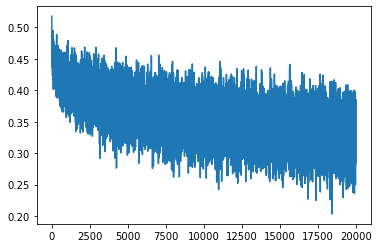

In [302]:
# plot the log train loss over iterations
plt.plot(lossi)

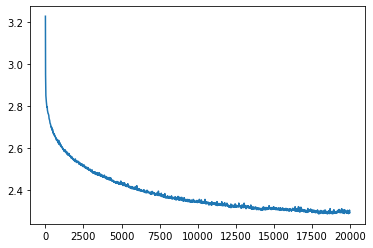

In [303]:
# plot the log val loss over iterations - the model seems to be overfitting to the training set (when more iterations used)
plt.plot(range(0, max_steps, 10), lossi_val);

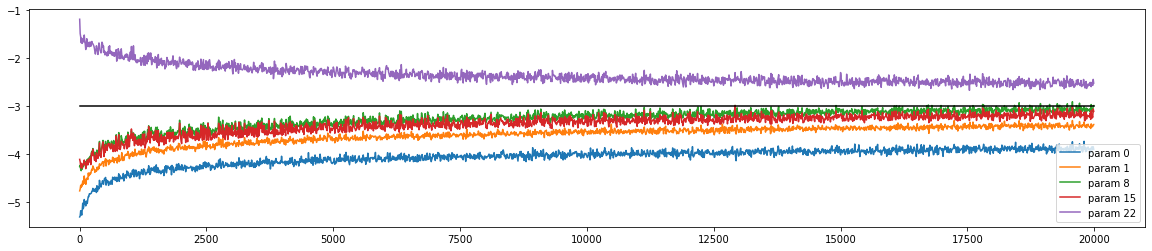

In [304]:
# this is an importand plot - the update to data val ratio
# if it is too large it could indicate exploding gradients
# if it is too small - vanishing gradients
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(net.parameters()):
    if p.ndim == 2:
        plt.plot(range(0, max_steps, 10), [update_to_data_ratio[j][i] for j in range(len(update_to_data_ratio))])
        legends.append(f"param {i}")
plt.plot([0, max_steps], [-3, -3], "k") # we want the update ratios to be ~1e-3
plt.legend(legends)
plt.show()
# if these values are too high we are updating too fast
# if they are too low it is indicative of a too small learning rate
# below we can clearly see when the learning rates change (when lr = 0.1 if i < 2000 else 0.01 if i < 5000 else 0.001 you get steps)

In [243]:
print("val loss:", split_loss("val"))
print("test loss:", split_loss("test"))

val loss: 2.2931292057037354
test loss: 2.2722976207733154


In [246]:
def predict_name():
    out = []
    context = [0] * block_size
    while True:
        # forward pass the neural net
        x = torch.tensor([context])
        logits = net(x, train=False)

        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, replacement=True).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we encounter the special "." token we break
        if ix == 0:
            break
    return "".join([itos[i] for i in out[:-1]])

[predict_name() for _ in range(10)]

['nyana',
 'raisia',
 'gtarii',
 'kayasilaqi',
 'orylegan',
 'deon',
 'ben',
 'hay',
 'wevi',
 'ilin']